In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *

from matplotlib.path import Path
%matplotlib inline

import math
import random
import pickle
import copy

Setting environment for Gordon


In [2]:
labels = ['BackG', '5N', '7n', '7N', '12N', 'Pn', 'VLL', 
          '6N', 'Amb', 'R', 'Tz', 'RtTg', 'LRt', 'LC', 'AP', 'sp5']

n_class = len(labels)

In [3]:
class Hypersphere_abstain:
    
    def __init__(self, center, radius, threshold, label, alpha, beta, D, err, weighted_err, unweighted_err,
                 label_confidences, label_distribution, center_index, neighbor_indices, d_var, max_q_var):
        
        self.center = center
        self.radius = radius
        self.thres = threshold
        self.label = label
        self.alpha = alpha
        self.beta = beta
        self.D = D 
        self.pseudo_err = err # PSEUDO error
        self.weighted_err = weighted_err
        self.unweighted_err = unweighted_err
        self.label_confidences = label_confidences
        self.label_distribution = label_distribution
        self.center_index = center_index
        self.neighbor_indices = neighbor_indices
        
        # Hack
        self.d_var = d_var
        self.max_q_var = max_q_var
        
class WeakLearner_generator:
    
    def __init__(self, init_radius, growth_radius, end_radius, abstain_thres, err_thres):
        
        self.init_radius = init_radius
        self.growth_radius = growth_radius
        self.end_radius = end_radius
        self.abstain_thres = abstain_thres
        self.err_thres = err_thres
        
    def generate_pseudo(self, train_X, train_y, train_kernel, D, Q, mask, n_class):
        
        n_samples = train_X.shape[0]
        D = D.reshape((n_samples, ))

        # Choose an exemplar
        exemplar_index = np.random.choice(range(n_samples), p=D.tolist())
        exemplar = train_X[exemplar_index]

        # Retrieve scores to exemplar and sort
        scores = train_kernel[exemplar_index]
        sorted_scores = np.sort(scores)[::-1]
        sorted_indices = np.argsort(scores)[::-1]
        sorted_y = train_y[sorted_indices].astype('int64')
        sorted_D = D[sorted_indices]
        sorted_Q = Q[sorted_indices]
        sorted_mask = mask[sorted_indices]
        
        # Calculate plurarity and percentage of initial sphere
        init_size = np.argmax(sorted_scores<self.init_radius)
        count = np.bincount(sorted_y[:init_size],
                            weights=sorted_D[:init_size],
                            minlength=n_class)
        unweighted_count = np.bincount(sorted_y[:init_size],
                                       minlength=n_class)
        y_of_interest = np.argmax(count)
        percentage = count[y_of_interest]*1.0 / np.sum(sorted_D[:init_size])

        # Abstain test (HACK to avoid zero threshold)
        if np.sum(sorted_scores)==0.0:
            return None, None
        
        # Calculate cumulative weight sums
        sorted_D_tile = np.tile(sorted_D.reshape((n_samples,1)), (1, n_class))
        label_D_cum = np.cumsum(sorted_D_tile*sorted_mask, axis=0)
        label_Dq_cum = np.cumsum(sorted_D_tile*~sorted_mask*sorted_Q, axis=0)

        # Hypothesis and pseudo loss
        radii = np.arange(self.end_radius, self.init_radius+self.growth_radius, self.growth_radius)[::-1]
        hypo = np.zeros((len(radii), n_class), dtype=bool)
        pseudo_loss = np.zeros((len(radii),1))
        
        # For each radius
        for c,r in enumerate(radii):
            
            i = np.argmax(sorted_scores<r)
            
            # Calculate best hypotheses
            deriv = -1.0*label_D_cum[i-1]+label_Dq_cum[i-1]
            hypo[c] = (deriv<0.0).astype('float')
            label_conf = np.tile(hypo[c], (n_samples, 1))
    
            # Calculate three terms in pseudo loss
            ones_term = np.ones((n_samples,1)).astype('float')
            label_term = np.sum(sorted_mask*label_conf, axis=1).reshape((n_samples,1)).astype('float')
            nonlabel_sum = np.sum(~sorted_mask*sorted_Q*label_conf, axis=1).reshape((n_samples,1)).astype('float')
            
            # Calculate pseudo loss
            pseudo_loss[c] = 0.5 * np.sum(sorted_D[:i].reshape((i,1))*(ones_term[:i] - label_term[:i] + nonlabel_sum[:i]))
            pseudo_loss[c] += 0.5 * np.sum(sorted_D[i:])
            
        # Calculate best radius
        best_idx = np.argmin(pseudo_loss)
        best_radius = np.argmax(sorted_scores<radii[best_idx])
        
        # Prediction by best radius hypothesis
        label_conf = hypo[best_idx]
        p_err = pseudo_loss[best_idx]
#         print 'BEST RADIUS: ', best_radius
        
#         if random.random()<0.01:
#             print 'BEST (Size, Ploss, Hypo): ', (best_radius, list(p_err), list(label_conf.astype('int')))

        # Calculate label distritbution
        label_distribution = np.bincount(sorted_y[:best_radius], minlength=n_class)
    
        # Error test
        if p_err>self.err_thres:
            return None, None
        
        # Calculate alpha
        epsilon = 1.0e-24
        alpha = math.log((1.0-p_err+epsilon)/(p_err+epsilon))
        beta = (p_err+epsilon)*1.0/(1.0-p_err-epsilon)

        # Return weakleaner
        err = 0.0
        w_err = 0.0
        threshold = sorted_scores[best_radius-1]
        
        d_var = np.var(D)
        max_q_var= np.max(np.var(sorted_Q, axis=1))
        
        h = Hypersphere_abstain(exemplar, best_radius, threshold, y_of_interest,
                                alpha, beta, D, p_err, w_err, err, label_conf, label_distribution,
                                exemplar_index, sorted_indices, d_var, max_q_var)
        
        return h, sorted_mask
    

In [4]:
# Adaboost.M2

class Adaboost_M2:
    
    def __init__(self, iterations, n_class, weaklearner):
        
        self.T = iterations
        self.H = []
        self.D = None
        self.Q = None
        self.W = None
        self.W_staged = [] #Hack
        self.label_mask = None
        self.n_class = n_class
        self.weaklearner = weaklearner
    
    def train(self, train_X, train_y, train_kernel):
        
        n_samples = train_X.shape[0]
        
        # Create column mask for weights
        rows = list(xrange(n_samples))
        cols = train_y.astype('int64').tolist()
        self.label_mask = np.zeros((n_samples, self.n_class), dtype=bool)
        self.label_mask[rows, cols] = True
        
        # Initialize weights
        self.D = np.ones((n_samples, 1))*(1.0/n_samples)
        self.W = np.zeros((n_samples, self.n_class)) + \
                    ~self.label_mask*np.tile(self.D, (1,n_class))*(1.0/(self.n_class-1))

        for t in xrange(self.T):

            if t%1000==0:
                print 't: ', t
                
            # Normalize
            W_sum = np.sum(self.W, axis=1).reshape((n_samples,1))
            self.Q = np.zeros((n_samples, self.n_class)) + \
                        self.W*1.0/np.tile(W_sum,(1,self.n_class))
            self.D = W_sum*1.0/np.sum(W_sum)
            
            # Generate weaklearner
            h, h_neighbor_label_mask = \
                self.weaklearner.generate_pseudo(train_X, train_y, train_kernel, self.D, self.Q, self.label_mask, self.n_class)
            
            # Check abstained
            if not h:
                continue
                
            self.H.append(h)

            # Reweight
            base_term = h.beta*np.ones((n_samples, self.n_class))
            ones_term = np.ones((n_samples, self.n_class)).astype('float')
            label_weights = np.tile(h.label_confidences.reshape((1, self.n_class)), (n_samples, 1))
            label_term = np.sum(h_neighbor_label_mask*label_weights, axis=1).reshape((n_samples, 1))
            label_term = np.tile(label_term, ((1, self.n_class))).astype('float')
            nonlabel_term = ~h_neighbor_label_mask*label_weights.astype('float')
            
            power_term = 0.5*(ones_term + label_term - nonlabel_term)
            
            neighbors_in_sphere = h.neighbor_indices[:h.radius]
            neighbors_out_sphere = h.neighbor_indices[h.radius:]
    
            self.W[neighbors_in_sphere] = self.W[neighbors_in_sphere] * \
                                            np.power(base_term[:h.radius], power_term[:h.radius])
            self.W[neighbors_out_sphere] = self.W[neighbors_out_sphere] * \
                                            np.power(base_term[h.radius:], 0.5*ones_term[h.radius:])
        
            self.W_staged.append(self.W)
            
        print 'Num classifiers: ', len(self.H)

    def predict(self, train_X, train_y, train_kernel=None):

        no_kernel = train_kernel==None
        n_samples = train_X.shape[0]
        cumulative_prob = np.zeros((n_samples, self.n_class)).astype('float')
        staged_pred_y = np.zeros((len(self.H), n_samples)).astype('int64')
        
        if no_kernel:
            
            def compute_intersection_kernel_oneJob(i):
                dist = np.minimum(self.H[i].center, test_X)
                dist = np.sum(dist, axis=1).reshape((1, n_samples))
                return dist
            
            score_kernel = np.concatenate([compute_intersection_kernel_oneJob(i) for i in xrange(len(self.H))], axis=0)
            print 'Test kernel shape: ', score_kernel.shape
            
        else:
            score_kernel = None

        for i in xrange(len(self.H)):
            
            clf = self.H[i]
            
            score = np.copy(score_kernel[i]) if no_kernel else np.copy(train_kernel[clf.center_index])
            score[score < clf.thres] = 0.0 #Abstain
            score[score >= clf.thres] = math.log(1.0/clf.beta)
            
            label_weights = clf.label_confidences.astype('float')
            cumulative_prob += np.multiply(score.reshape((n_samples,1)), label_weights.reshape((1,self.n_class)))
                
            max_prob = np.max(cumulative_prob, axis=1)
            pred_y = np.argmax(cumulative_prob, axis=1)
            pred_y[max_prob==0.0] = 0
            staged_pred_y[i,:] = pred_y
        
        print 'Correct predictions: ', np.sum(train_y==staged_pred_y[-1])
        
        return staged_pred_y



Experiment #0
(5969, 200)
(5969, 5969)
(4462, 200)
(4462, 4462)
(3729, 200)
(3729, 3729)
(2224, 200)
(2224, 2224)
(745, 200)
(745, 745)
(1495, 200)
t:  0
t:  1000
t:  2000
t:  3000
t:  4000
t:  5000
t:  6000
t:  7000
t:  8000
t:  9000
t:  10000
t:  11000
t:  12000
t:  13000
t:  14000
t:  15000
t:  16000
t:  17000
t:  18000
t:  19000
Num classifiers: 

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in double_scalars
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:72: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


 17696
Correct predictions:  4988
Test kernel shape:  (17696, 1495)
Correct predictions:  875
t:  0
t:  1000
t:  2000
t:  3000
t:  4000
t:  5000
t:  6000
t:  7000
t:  8000
t:  9000
t:  10000
t:  11000
t:  12000
t:  13000
t:  14000
t:  15000
t:  16000
t:  17000
t:  18000
t:  19000
Num classifiers:  17212
Correct predictions:  3915
Test kernel shape:  (17212, 1495)
Correct predictions:  865
t:  0
t:  1000
t:  2000
t:  3000
t:  4000
t:  5000
t:  6000
t:  7000
t:  8000
t:  9000
t:  10000
t:  11000
t:  12000
t:  13000
t:  14000
t:  15000
t:  16000
t:  17000
t:  18000
t:  19000
Num classifiers:  17135
Correct predictions:  3410
Test kernel shape:  (17135, 1495)
Correct predictions:  847
t:  0
t:  1000
t:  2000
t:  3000
t:  4000
t:  5000
t:  6000
t:  7000
t:  8000
t:  9000
t:  10000
t:  11000
t:  12000
t:  13000
t:  14000
t:  15000
t:  16000
t:  17000
t:  18000
t:  19000
Num classifiers:  16484
Correct predictions:  2155
Test kernel shape:  (16484, 1495)
Correct predictions:  800
t:  0
t:  10

Experiment #0 time: 1694.648184 seconds
Experiment #1 time: 1706.013530 seconds




Experiment #2
(5969, 200)
(5969, 5969)
(4462, 200)
(4462, 4462)
(3729, 200)
(3729, 3729)
(2224, 200)
(2224, 2224)
(745, 200)
(745, 745)
(1495, 200)
t:  0
t:  1000
t:  2000
t:  3000
t:  4000
t:  5000
t:  6000
t:  7000
t:  8000
t:  9000
t:  10000
t:  11000
t:  12000
t:  13000
t:  14000
t:  15000
t:  16000
t:  17000
t:  18000
t:  19000
Num classifiers:  17872
Correct predictions:  5007
Test kernel shape:  (17872, 1495)
Correct predictions:  892
t:  0
t:  1000
t:  2000
t:  3000
t:  4000
t:  5000
t:  6000
t:  7000
t:  8000
t:  9000
t:  10000
t:  11000
t:  12000
t:  13000
t:  14000
t:  15000
t:  16000
t:  17000
t:  18000
t:  19000
Num classifiers:  17616
Correct predictions:  3984
Test kernel shape:  (17616, 1495)
Correct predictions:  864
t:  0
t:  1000
t:  2000
t:  3000
t:  4000
t:  5000
t:  6000
t:  7000
t:  8000
t:  9000
t:  10000
t:  11000
t:  12000
t:  13000
t:  14000
t:  15000
t:  16000
t:  17000
t:  18000
t:  19000
Num classifiers:  17333
Correct predictions:  3438
Test kernel shap

Experiment #2 time: 1720.989512 seconds
Experiment #3 time: 1734.946891 seconds




Experiment #4
(5969, 200)
(5969, 5969)
(4462, 200)
(4462, 4462)
(3729, 200)
(3729, 3729)
(2224, 200)
(2224, 2224)
(745, 200)
(745, 745)
(1495, 200)
t:  0
t:  1000
t:  2000
t:  3000
t:  4000
t:  5000
t:  6000
t:  7000
t:  8000
t:  9000
t:  10000
t:  11000
t:  12000
t:  13000
t:  14000
t:  15000
t:  16000
t:  17000
t:  18000
t:  19000
Num classifiers:  17758
Correct predictions:  4989
Test kernel shape:  (17758, 1495)
Correct predictions:  831
t:  0
t:  1000
t:  2000
t:  3000
t:  4000
t:  5000
t:  6000
t:  7000
t:  8000
t:  9000
t:  10000
t:  11000
t:  12000
t:  13000
t:  14000
t:  15000
t:  16000
t:  17000
t:  18000
t:  19000
Num classifiers:  17632
Correct predictions:  4001
Test kernel shape:  (17632, 1495)
Correct predictions:  832
t:  0
t:  1000
t:  2000
t:  3000
t:  4000
t:  5000
t:  6000
t:  7000
t:  8000
t:  9000
t:  10000
t:  11000
t:  12000
t:  13000
t:  14000
t:  15000
t:  16000
t:  17000
t:  18000
t:  19000
Num classifiers:  16802
Correct predictions:  3384
Test kernel shap

Experiment #4 time: 1711.137990 seconds


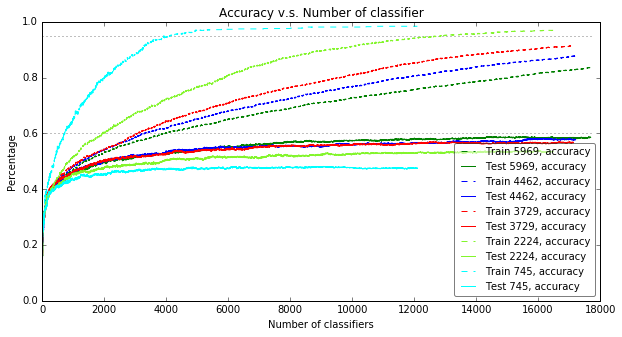

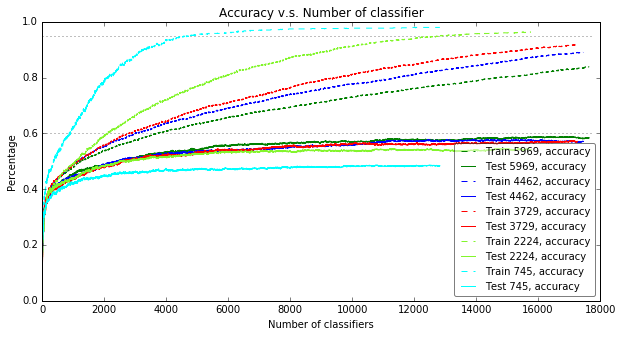

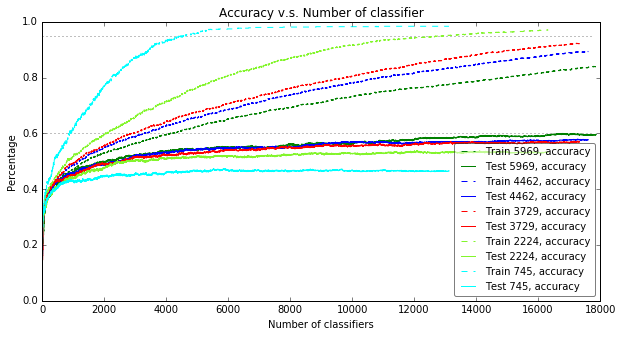

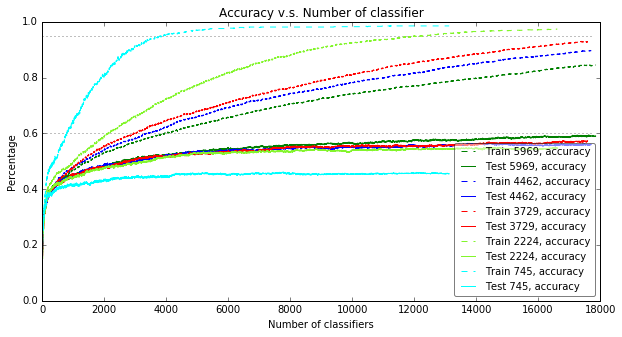

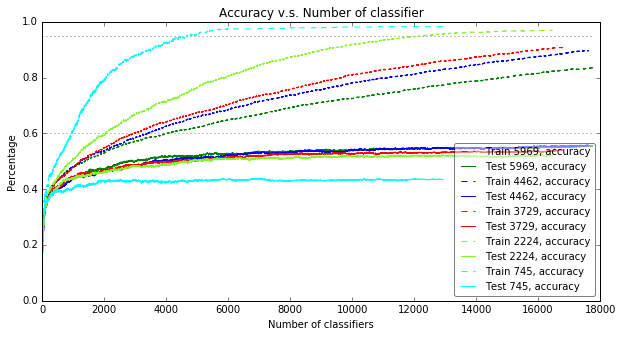

In [14]:
# LEVEL=0, 500patches, 8-2 and 6-4 and 5-5 and 3-7 and 1-9

exprmt = 10

# for e in xrange(exprmt):
# for e in [2, 3, 4, 5, 6]:
for e in [0, 1, 2, 3, 4]:
    
    print '\nExperiment #%d' %e
    
    tim = time.time()

    # Load preprocessed data
    train_X_82 = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_level0_82_e%d_data.bp'%e)
    train_y_82 = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_level0_82_e%d_labels.bp'%e)
    train_kernel_82 = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_level0_82_e%d_spm_dist_mat.bp'%e)
    train_fnames_82 = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_level0_82_e%d_fnames.bp'%e)
    
    train_X_64 = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_level0_64_e%d_data.bp'%e)
    train_y_64 = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_level0_64_e%d_labels.bp'%e)
    train_kernel_64 = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_level0_64_e%d_spm_dist_mat.bp'%e)
    train_fnames_64 = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_level0_64_e%d_fnames.bp'%e)
    
    train_X_55 = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_level0_55_e%d_data.bp'%e)
    train_y_55 = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_level0_55_e%d_labels.bp'%e)
    train_kernel_55 = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_level0_55_e%d_spm_dist_mat.bp'%e)
    train_fnames_55 = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_level0_55_e%d_fnames.bp'%e)

    train_X_37 = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_level0_37_e%d_data.bp'%e)
    train_y_37 = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_level0_37_e%d_labels.bp'%e)
    train_kernel_37 = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_level0_37_e%d_spm_dist_mat.bp'%e)
    train_fnames_37 = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_level0_37_e%d_fnames.bp'%e)

    train_X_19 = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_level0_19_e%d_data.bp'%e)
    train_y_19 = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_level0_19_e%d_labels.bp'%e)
    train_kernel_19 = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_level0_19_e%d_spm_dist_mat.bp'%e)
    train_fnames_19 = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_level0_19_e%d_fnames.bp'%e)

    test_X = bp.unpack_ndarray_file('sift-jpeg/preprocessed/test_level0_e%d_data.bp'%e)
    test_y = bp.unpack_ndarray_file('sift-jpeg/preprocessed/test_level0_e%d_labels.bp'%e)
    test_fnames = bp.unpack_ndarray_file('sift-jpeg/preprocessed/test_level0_e%d_fnames.bp'%e)
    
    print train_X_82.shape
    print train_kernel_82.shape
    print train_X_64.shape
    print train_kernel_64.shape
    print train_X_55.shape
    print train_kernel_55.shape
    print train_X_37.shape
    print train_kernel_37.shape
    print train_X_19.shape
    print train_kernel_19.shape
    print test_X.shape
    
    # Setup, Train, and Predict
    weak = WeakLearner_generator(init_radius=0.5,
                                 growth_radius=0.05,
                                 end_radius=0.1,
                                 abstain_thres=0.5,
                                 err_thres=1.0)
    ada = Adaboost_M2(iterations=20000, 
                      n_class=n_class, 
                      weaklearner=weak)
    ada.train(train_X_82, train_y_82, train_kernel_82)
    staged_pred_y_82 = ada.predict(train_X_82, train_y_82, train_kernel_82)
    staged_pred_y_test_82 = ada.predict(test_X, test_y)
    del weak
    del ada
    
    weak = WeakLearner_generator(init_radius=0.5,
                                 growth_radius=0.05,
                                 end_radius=0.1,
                                 abstain_thres=0.5,
                                 err_thres=1.0)
    ada = Adaboost_M2(iterations=20000, 
                      n_class=n_class, 
                      weaklearner=weak)
    ada.train(train_X_64, train_y_64, train_kernel_64)
    staged_pred_y_64 = ada.predict(train_X_64, train_y_64, train_kernel_64)
    staged_pred_y_test_64 = ada.predict(test_X, test_y)
    del weak
    del ada
    
    weak = WeakLearner_generator(init_radius=0.5,
                                 growth_radius=0.05,
                                 end_radius=0.1,
                                 abstain_thres=0.5,
                                 err_thres=1.0)
    ada = Adaboost_M2(iterations=20000, 
                      n_class=n_class, 
                      weaklearner=weak)
    ada.train(train_X_55, train_y_55, train_kernel_55)
    staged_pred_y_55 = ada.predict(train_X_55, train_y_55, train_kernel_55)
    staged_pred_y_test_55 = ada.predict(test_X, test_y)
    del weak
    del ada

    weak = WeakLearner_generator(init_radius=0.5,
                                 growth_radius=0.05,
                                 end_radius=0.1,
                                 abstain_thres=0.5,
                                 err_thres=1.0)
    ada = Adaboost_M2(iterations=20000, 
                      n_class=n_class, 
                      weaklearner=weak)
    ada.train(train_X_37, train_y_37, train_kernel_37)
    staged_pred_y_37 = ada.predict(train_X_37, train_y_37, train_kernel_37)
    staged_pred_y_test_37 = ada.predict(test_X, test_y)
    del weak
    del ada

    weak = WeakLearner_generator(init_radius=0.5,
                                 growth_radius=0.05,
                                 end_radius=0.1,
                                 abstain_thres=0.5,
                                 err_thres=1.0)
    ada = Adaboost_M2(iterations=20000, 
                      n_class=n_class, 
                      weaklearner=weak)
    ada.train(train_X_19, train_y_19, train_kernel_19)
    staged_pred_y_19 = ada.predict(train_X_19, train_y_19, train_kernel_19)
    staged_pred_y_test_19 = ada.predict(test_X, test_y)
    del weak
    del ada
    
    # Calculate accuracy
    train_acc_82=[]
    n_training_82 = staged_pred_y_82.shape[1]
    t_training_82 = len(staged_pred_y_82)
    test_acc_82=[]
    n_testing_82 = staged_pred_y_test_82.shape[1]
    t_testing_82 = len(staged_pred_y_test_82)
    for t in xrange(t_training_82):
        train_acc_82.append(np.sum(staged_pred_y_82[t]==train_y_82)*1.0/n_training_82)
        test_acc_82.append(np.sum(staged_pred_y_test_82[t]==test_y)*1.0/n_testing_82)
    
    train_acc_64=[]
    n_training_64 = staged_pred_y_64.shape[1]
    t_training_64 = len(staged_pred_y_64)
    test_acc_64=[]
    n_testing_64 = staged_pred_y_test_64.shape[1]
    t_testing_64 = len(staged_pred_y_test_64)
    for t in xrange(t_training_64):
        train_acc_64.append(np.sum(staged_pred_y_64[t]==train_y_64)*1.0/n_training_64)
        test_acc_64.append(np.sum(staged_pred_y_test_64[t]==test_y)*1.0/n_testing_64)
    
    train_acc_55=[]
    n_training_55 = staged_pred_y_55.shape[1]
    t_training_55 = len(staged_pred_y_55)
    test_acc_55=[]
    n_testing_55 = staged_pred_y_test_55.shape[1]
    t_testing_55 = len(staged_pred_y_test_55)
    for t in xrange(t_training_55):
        train_acc_55.append(np.sum(staged_pred_y_55[t]==train_y_55)*1.0/n_training_55)
        test_acc_55.append(np.sum(staged_pred_y_test_55[t]==test_y)*1.0/n_testing_55)

    train_acc_37=[]
    n_training_37 = staged_pred_y_37.shape[1]
    t_training_37 = len(staged_pred_y_37)
    test_acc_37=[]
    n_testing_37 = staged_pred_y_test_37.shape[1]
    t_testing_37 = len(staged_pred_y_test_37)
    for t in xrange(t_training_37):
        train_acc_37.append(np.sum(staged_pred_y_37[t]==train_y_37)*1.0/n_training_37)
        test_acc_37.append(np.sum(staged_pred_y_test_37[t]==test_y)*1.0/n_testing_37)

    train_acc_19=[]
    n_training_19 = staged_pred_y_19.shape[1]
    t_training_19 = len(staged_pred_y_19)
    test_acc_19=[]
    n_testing_19 = staged_pred_y_test_19.shape[1]
    t_testing_19 = len(staged_pred_y_test_19)
    for t in xrange(t_training_19):
        train_acc_19.append(np.sum(staged_pred_y_19[t]==train_y_19)*1.0/n_training_19)
        test_acc_19.append(np.sum(staged_pred_y_test_19[t]==test_y)*1.0/n_testing_19)
        
    print 'Training 82: ', n_training_82
    print 'Final Accuracy: ', train_acc_82[-1]
    print 'Testing 82: ', n_testing_82
    print 'Final Accuracy: ', test_acc_82[-1]
    
    print 'Training 64: ', n_training_64
    print 'Final Accuracy: ', train_acc_64[-1]
    print 'Testing 64: ', n_testing_64
    print 'Final Accuracy: ', test_acc_64[-1]
    
    print 'Training 55: ', n_training_55
    print 'Final Accuracy: ', train_acc_55[-1]
    print 'Testing 55: ', n_testing_55
    print 'Final Accuracy: ', test_acc_55[-1]

    print 'Training 37: ', n_training_37
    print 'Final Accuracy: ', train_acc_37[-1]
    print 'Testing 37: ', n_testing_37
    print 'Final Accuracy: ', test_acc_37[-1]

    print 'Training 19: ', n_training_19
    print 'Final Accuracy: ', train_acc_19[-1]
    print 'Testing 19: ', n_testing_19
    print 'Final Accuracy: ', test_acc_19[-1]
    
    plt.figure(figsize=(10,5));
    plt.title("Accuracy v.s. Number of classifier");
    plt.xlabel("Number of classifiers");
    plt.ylabel("Percentage");
    plt.ylim([0.0, 1.0]);
    plt.plot(range(1, len(train_acc_82) + 1), train_acc_82, label='Train %d, accuracy'%n_training_82, linestyle='dashed', color='green');
    plt.plot(range(1, len(test_acc_82) + 1), test_acc_82, label='Test %d, accuracy'%n_training_82, color='green');
    plt.plot(range(1, len(train_acc_64) + 1), train_acc_64, label='Train %d, accuracy'%n_training_64, linestyle='dashed', color='blue');
    plt.plot(range(1, len(test_acc_64) + 1), test_acc_64, label='Test %d, accuracy'%n_training_64, color='blue');
    plt.plot(range(1, len(train_acc_55) + 1), train_acc_55, label='Train %d, accuracy'%n_training_55, linestyle='dashed', color='red');
    plt.plot(range(1, len(test_acc_55) + 1), test_acc_55, label='Test %d, accuracy'%n_training_55, color='red');
    plt.plot(range(1, len(train_acc_37) + 1), train_acc_37, label='Train %d, accuracy'%n_training_37, linestyle='dashed', color='#83F52C');
    plt.plot(range(1, len(test_acc_37) + 1), test_acc_37, label='Test %d, accuracy'%n_training_37, color='#83F52C');
    plt.plot(range(1, len(train_acc_19) + 1), train_acc_19, label='Train %d, accuracy'%n_training_19, linestyle='dashed', color='cyan');
    plt.plot(range(1, len(test_acc_19) + 1), test_acc_19, label='Test %d, accuracy'%n_training_19, color='cyan');
    plt.hlines(0.95, 1, 17800, linestyles=':', color='grey');
    plt.hlines(0.60, 1, 17800, linestyles=':', color='grey');
#     plt.hlines(0.95, 1, 20, linestyles=':', color='grey');
#     plt.hlines(0.60, 1, 20, linestyles=':', color='grey');
    plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10);
    
    print ''
    del train_X_82
    del train_y_82
    del train_kernel_82
    del train_fnames_82
    del train_X_64
    del train_y_64
    del train_kernel_64
    del train_fnames_64
    del train_X_55
    del train_y_55
    del train_kernel_55
    del train_fnames_55
    del train_X_37
    del train_y_37
    del train_kernel_37
    del train_fnames_37
    del train_X_19
    del train_y_19
    del train_kernel_19
    del train_fnames_19
    del test_X
    del test_y
    del test_fnames
    del staged_pred_y_82
    del staged_pred_y_test_82
    del staged_pred_y_64
    del staged_pred_y_test_64
    del staged_pred_y_55
    del staged_pred_y_test_55
    del staged_pred_y_37
    del staged_pred_y_test_37
    del staged_pred_y_19
    del staged_pred_y_test_19

    sys.stderr.write('Experiment #%d time: %f seconds\n' % (e, (time.time() - tim))) # ~ 2s / 12k training data

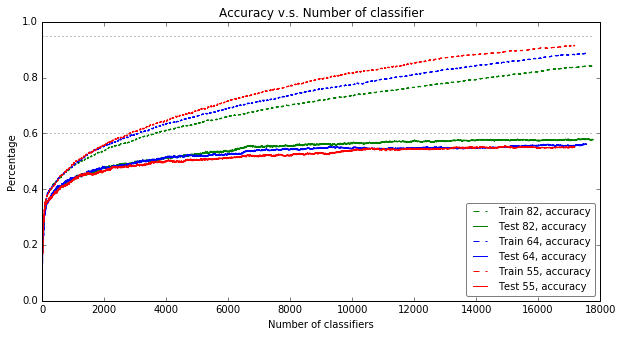

In [23]:
plt.figure(figsize=(10,5));
plt.title("Accuracy v.s. Number of classifier");
plt.xlabel("Number of classifiers");
plt.ylabel("Percentage");
plt.ylim([0.0, 1.0]);
plt.plot(range(1, len(train_acc_82) + 1), train_acc_82, label='Train 82, accuracy', linestyle='dashed', color='green');
plt.plot(range(1, len(test_acc_82) + 1), test_acc_82, label='Test 82, accuracy', color='green');
plt.plot(range(1, len(train_acc_64) + 1), train_acc_64, label='Train 64, accuracy', linestyle='dashed', color='blue');
plt.plot(range(1, len(test_acc_64) + 1), test_acc_64, label='Test 64, accuracy', color='blue');
plt.plot(range(1, len(train_acc_55) + 1), train_acc_55, label='Train 55, accuracy', linestyle='dashed', color='red');
plt.plot(range(1, len(test_acc_55) + 1), test_acc_55, label='Test 55, accuracy', color='red');
plt.hlines(0.95, 1, 17800, linestyles=':', color='grey');
plt.hlines(0.60, 1, 17800, linestyles=':', color='grey');
plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10);

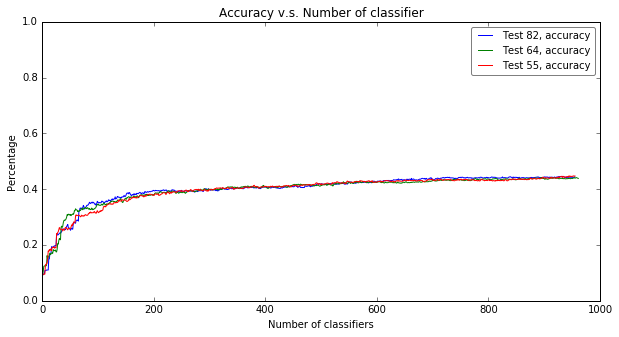